In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm as tqdm

In [3]:
"""
MONTH - a month claims were lodged
SERVICE_CATEGORY - a department that provided services to patients
CLAIM_SPECIALTY - a type of medical services by an official classification system
PAYER - an insurance company
PAID_AMOUNT - sum of expenses (claims), $
"""

def wrangle(path):
    '''
    Function created after data exploration and 
    data quality analysis in each column.

    I saved PCPEncounter with only 42 observation because 
    it has can enough data for analysis
    '''
    
    df = pd.read_csv(path)
    
    # drop bad date and rare date in column 'MONTH'
    mask1 = df['MONTH'] != 201900
    mask2 = df['MONTH'] != 202007
    df = df[mask1 & mask2]
    
    # date to datetime
    df['date'] = pd.to_datetime(df['MONTH'], format='%Y%m') # , errors='coerce'
    
    # replace the same service category
    df['SERVICE_CATEGORY'] = df['SERVICE_CATEGORY'].replace("SpecialistsFFS",'SpecialistFFS')    
    
    # drop NaN CLAIM_SPECIALTY
    df.dropna(subset=['CLAIM_SPECIALTY'], inplace=True)
    
    # choose only one type of payments
    df = df[df.PAID_AMOUNT > 0]
    df['PAID_AMOUNT'] = df['PAID_AMOUNT'].astype('int64')
    
    # choose payments between quantiles without outliers
    q1, q9 = df.PAID_AMOUNT.quantile([0.01, 0.99])
    df = df[df.PAID_AMOUNT.between(q1,q9)]
    
    # add season and month as a category
    df['month'] = df['date'].dt.month.astype(str)
                   
    df['SEASON'] = (df['date'].dt.month
                   .astype(str)
                   .replace(['12','1','2'],'winter')
                   .replace(['3','4','5'],'spring')
                   .replace(['6','7','8'],'summer')
                   .replace(['9','10','11'],'autumn')
                   )  
    
    print('q1:', round(q1), 'q9:', round(q9))
    print()
    print('isna_sum:', df.isna().mean().sum())
    print()
    print('df_shape is: ', df.shape)
    
    print(df.dtypes)
    
    return df
    
path = "claims_sample_data.csv"

df = wrangle(path)
df.head(5)

q1: 14 q9: 54388

isna_sum: 0.0

df_shape is:  (46734, 8)
MONTH                        int64
SERVICE_CATEGORY            object
CLAIM_SPECIALTY             object
PAYER                       object
PAID_AMOUNT                  int64
date                datetime64[ns]
month                       object
SEASON                      object
dtype: object


,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,date,month,SEASON
4,201801,AncillaryFFS,ACH,Payer W,151,2018-01-01,1,winter
6,201801,AncillaryFFS,ADVANCED RN PRACT,Payer CA,443,2018-01-01,1,winter
7,201801,AncillaryFFS,AMBULANCE,Payer CA,14890,2018-01-01,1,winter
8,201801,AncillaryFFS,AMBULANCE,Payer CO,1722,2018-01-01,1,winter
9,201801,AncillaryFFS,AMBULANCE,Payer F,36108,2018-01-01,1,winter


In [4]:
df['date'].agg(['min', 'max'])

min   2018-01-01
max   2020-06-01
Name: date, dtype: datetime64[ns]

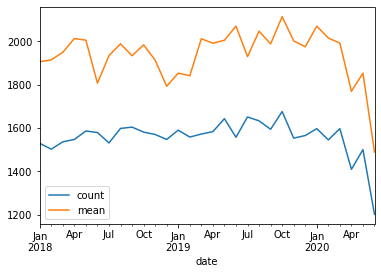

In [8]:
df.groupby('date')['PAID_AMOUNT'].agg(['count', 'mean']).plot();

In [9]:
(df.groupby(['CLAIM_SPECIALTY'])['PAID_AMOUNT']
 .agg(['count', 'mean', 'sum'])
 .sort_values(by='count', ascending=False)
)

,count,mean,sum
CLAIM_SPECIALTY,,,
INTERNAL MEDICINE,1084,3990.092251,4325260
FAMILY PRACTICE,998,1869.682365,1865943
GENERAL SURGERY,798,1869.350877,1491742
GENERAL PRACTICE,777,1263.491634,981733
RADIOLOGY,749,3570.702270,2674456
...,...,...,...
Neuropsychology,1,224.000000,224
SPHEAR,1,155.000000,155
Neonatology,1,606.000000,606


In [10]:
# Select features with enought data
top_specialty = (df.groupby('CLAIM_SPECIALTY')['PAID_AMOUNT']
             .agg(['count','mean'])
             .sort_values(by='count', ascending=False)
            )
top_specialty = top_specialty[top_specialty['count'] > 10]
print(len(top_specialty))
top_specialty

450


,count,mean
CLAIM_SPECIALTY,,
INTERNAL MEDICINE,1084,3990.092251
FAMILY PRACTICE,998,1869.682365
GENERAL SURGERY,798,1869.350877
GENERAL PRACTICE,777,1263.491634
RADIOLOGY,749,3570.702270
...,...,...
Internal Medicine - Infectious Disease\t,11,533.909091
TRAUMA SURGERY,11,469.090909
PERSONAL EMERGENCY RESPONSE SYSTEM,11,42.272727


# Model

In [11]:
df.columns

Index(['MONTH', 'SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'PAID_AMOUNT',
       'date', 'month', 'SEASON'],
      dtype='object')

In [12]:
# Create the feature matrix and the target vector
features = ['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'SEASON']
target = "PAID_AMOUNT"

train = df.sample(frac=0.7,random_state=42).copy()
val = df[~df.index.isin(train.index)].copy()

In [13]:
# Baseline model
y_mean = train['PAID_AMOUNT'].mean()
y_pred_baseline = [y_mean] * len(train)
mae_baseline = mean_absolute_error(train[target], y_pred_baseline)

print("Mean payment:", round(y_mean))
print("Baseline MAE:", round(mae_baseline))

Mean payment: 1934
Baseline MAE: 2097


In [14]:
# CatBoostRegressor
model_1 = CatBoostRegressor(verbose=100, 
                          eval_metric='RMSE',
                          random_state=42
                         )

model_1.fit(train[features], train[target],
          cat_features=features,
          eval_set=(val[features],val[target])
         )

y_pred_training = model_1.predict(val[features])
print("Training MAE:", mean_absolute_error(val[target], y_pred_training))

Learning rate set to 0.088046
0:	learn: 4711.7007232	test: 4803.0938571	best: 4803.0938571 (0)	total: 73.1ms	remaining: 1m 13s
100:	learn: 2895.9410102	test: 2554.7146897	best: 2554.7146897 (100)	total: 724ms	remaining: 6.44s
200:	learn: 2631.2744275	test: 2324.0269451	best: 2323.7947078 (199)	total: 1.42s	remaining: 5.64s
300:	learn: 2515.6803277	test: 2233.2157887	best: 2233.2157887 (300)	total: 2.04s	remaining: 4.74s
400:	learn: 2458.2302201	test: 2198.8000955	best: 2198.7682659 (398)	total: 2.66s	remaining: 3.97s
500:	learn: 2391.6878836	test: 2161.9745591	best: 2161.9745591 (500)	total: 3.27s	remaining: 3.26s
600:	learn: 2327.3518973	test: 2132.2744275	best: 2132.1788137 (597)	total: 3.89s	remaining: 2.58s
700:	learn: 2285.3408865	test: 2119.0970351	best: 2118.3639517 (693)	total: 4.52s	remaining: 1.93s
800:	learn: 2236.5959963	test: 2101.4476356	best: 2100.6166834 (794)	total: 5.14s	remaining: 1.28s
900:	learn: 2201.0000856	test: 2097.0532561	best: 2097.0532561 (900)	total: 5.75s

## MAE is reduced, so the model can be exist and has explanation power

In [212]:
# power of each feature
fi = pd.DataFrame({'feature':features,'fi':model_1.feature_importances_})
fi = fi.sort_values('fi',ascending=False)
fi

,feature,fi
1,CLAIM_SPECIALTY,43.254122
2,PAYER,28.306758
0,SERVICE_CATEGORY,26.647935
3,SEASON,1.791186


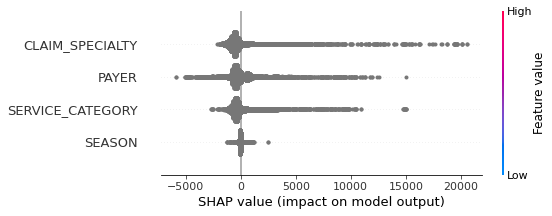

In [213]:
# shap plotting
explainer = shap.Explainer(model_1)
shap_values = explainer(val[features])

shap.summary_plot(shap_values,
                 val[features],
                 max_display = 50)

# Bootstrap model

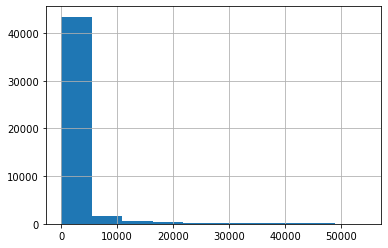

In [248]:
# The data don't have normal distribution
df['PAID_AMOUNT'].hist();

  0%|          | 0/10000 [00:00<?, ?it/s]

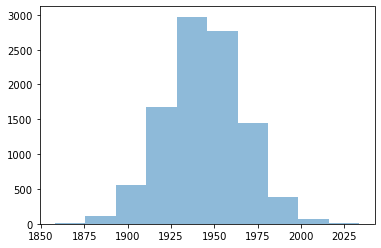

In [414]:
# Bootstrap all data set
my_samples = []

for _ in tqdm(range(10000)):
    x = np.random.choice(df['PAID_AMOUNT'], size=round(len(df['PAID_AMOUNT'])), replace=True)
    my_samples.append(x.mean())
    
plt.hist(my_samples, alpha=0.5);

In [385]:
# create diction from unique features for loop 
df_top = df[df['CLAIM_SPECIALTY'].isin(top_specialty.index)]
df_top = df_top[['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER']].drop_duplicates()
dict_ = df_top.T.to_dict()

In [386]:
# Bootstrap features in df
my_lst = []

for k,v in tqdm(dict_.items()):
    lst = []
    for i,j in v.items():
        lst.append(j)
        
    t = (df[ (df['SERVICE_CATEGORY'] == lst[0]) & 
             (df['CLAIM_SPECIALTY'] == lst[1]) & 
             (df['PAYER'] == lst[2])]
        )   
    
    for _ in range(5000):
        x = np.random.choice(t['PAID_AMOUNT'], size=round(len(t['PAID_AMOUNT'])), replace=True)
        my_lst.append([lst[0], lst[1], lst[2], x.mean()])

  0%|          | 0/3213 [00:00<?, ?it/s]

In [388]:
# Create df after Bootstrap
my_df = pd.DataFrame(my_lst, columns=['SERVICE_CATEGORY','CLAIM_SPECIALTY','PAYER','PAID_AMOUNT'])
print(len(my_df))
my_df.head()

16065000


,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT
0,AncillaryFFS,ADVANCED RN PRACT,Payer CA,483.464286
1,AncillaryFFS,ADVANCED RN PRACT,Payer CA,538.642857
2,AncillaryFFS,ADVANCED RN PRACT,Payer CA,633.750000
3,AncillaryFFS,ADVANCED RN PRACT,Payer CA,648.357143
4,AncillaryFFS,ADVANCED RN PRACT,Payer CA,567.821429


<AxesSubplot:>

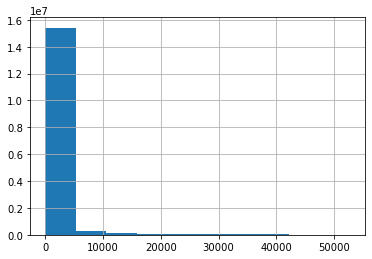

In [389]:
my_df.PAID_AMOUNT.hist()

29


<AxesSubplot:>

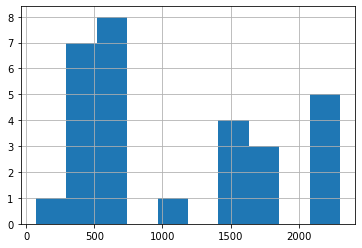

In [396]:
# exsample before Bootstrap
t = (df[(df['SERVICE_CATEGORY'] == 'AncillaryFFS') &
           (df['CLAIM_SPECIALTY'] == 'AMBULATORY SURGICAL CENTER') &
           (df['PAYER'] == 'Payer W')]
    )
print(len(t))
t.PAID_AMOUNT.hist();

5000


<AxesSubplot:>

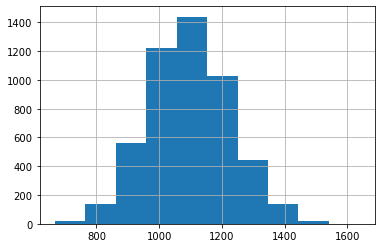

In [395]:
# exsample after Bootstrap
t = (my_df[(my_df['SERVICE_CATEGORY'] == 'AncillaryFFS') &
           (my_df['CLAIM_SPECIALTY'] == 'AMBULATORY SURGICAL CENTER') &
           (my_df['PAYER'] == 'Payer W')]
    )
print(len(t))
t.PAID_AMOUNT.hist();

In [397]:
# New train, val for Bootstrap model
features = ['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER']
target = "PAID_AMOUNT"

train = my_df.sample(frac=0.7,random_state=42).copy()
val = my_df[~my_df.index.isin(train.index)].copy()
print(len(train), len(val))

11245500 4819500


In [398]:
# CatBoostRegressor
model_2 = CatBoostRegressor(verbose=100, 
                          eval_metric='RMSE',
                          random_state=42
                         )

model_2.fit(train[features], train[target],
          cat_features=features,
          eval_set=(val[features],val[target])
         )

y_pred_training = model_2.predict(val[features])
print("Training MAE:", mean_absolute_error(val[target], y_pred_training))

Learning rate set to 0.220242
0:	learn: 3645.8667051	test: 3648.4605523	best: 3648.4605523 (0)	total: 9.03s	remaining: 2h 30m 21s
100:	learn: 1208.2196213	test: 1176.1796084	best: 1176.1796084 (100)	total: 4m 6s	remaining: 36m 36s
200:	learn: 834.8445606	test: 782.6905882	best: 782.6905882 (200)	total: 7m 4s	remaining: 28m 6s
300:	learn: 667.0791133	test: 611.3419208	best: 611.3419208 (300)	total: 10m 5s	remaining: 23m 25s
400:	learn: 587.5457040	test: 526.2397737	best: 526.2397737 (400)	total: 13m 29s	remaining: 20m 9s
500:	learn: 539.2996748	test: 480.2069895	best: 480.2069895 (500)	total: 16m 39s	remaining: 16m 35s
600:	learn: 511.4837017	test: 452.2259109	best: 452.2259109 (600)	total: 19m 26s	remaining: 12m 54s
700:	learn: 488.5149279	test: 433.0790281	best: 433.0790281 (700)	total: 22m 35s	remaining: 9m 38s
800:	learn: 473.3124296	test: 420.3959653	best: 420.3959653 (800)	total: 26m 20s	remaining: 6m 35s
900:	learn: 461.7323747	test: 412.6823560	best: 412.6823560 (900)	total: 29m

In [420]:
df_top = df[df['CLAIM_SPECIALTY'].isin(top_specialty.index)]
print("Training MAE:", mean_absolute_error(df[target], y_pred_training))

Training MAE: 826.6015796976708


# MAE is decreased after Bootstrap

# Forecast for 6 months

<AxesSubplot:xlabel='date'>

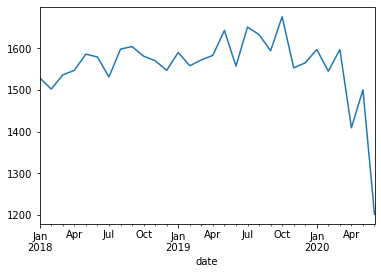

In [22]:
df.groupby('date')['PAID_AMOUNT'].agg('count').plot()

## The main question is: is the data for 2020-06 valid or is it a mistake?

In [30]:
t = df[df.date == '2020-06-01']
(t.groupby(['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER'])['PAID_AMOUNT']
 .agg(['count', 'mean'])
 .sort_values(by='count', ascending=False)
)

count    mean
SERVICE_CATEGORY  CLAIM_SPECIALTY           PAYER                  
ASCServices       AMBULATORY SURGERY CENTER Payer B       1   625.0
SNFServices       Family Practice           Payer B       1   192.0
                  FAMILY PRACTICE           Payer O       1   424.0
                                            Payer F       1  1524.0
                                            Payer CA      1   320.0
...                                                     ...     ...
InpatientServices CARDIOLOGY                Payer F       1  5880.0
                                            Payer CA      1  1057.0
                  CARDIAC ELECTROPHYSIOLOGY Payer W       1   184.0
                                            Payer O       1   418.0
SpecialistFFS     Vascular Surgery          Payer B       1   456.0

[1201 rows x 2 columns]

In [33]:
t = df[df.date == '2020-05-01']
(t.groupby(['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER'])['PAID_AMOUNT']
 .agg(['count', 'mean'])
 .sort_values(by='count', ascending=False)
)

count  \
SERVICE_CATEGORY  CLAIM_SPECIALTY                        PAYER             
ASCServices       AMBULATORY SURGERY CENTER              Payer B       1   
PCPFFS            Family Practice                        Payer B       1   
                  INTERNAL MEDICINE                      Payer B       1   
                  Hospitalist                            Payer UN      1   
                  General Surgery                        Payer UN      1   
...                                                                  ...   
InpatientServices ADVANCED REGISTERED NURSE PRACTITIONER Payer B       1   
                  ADLMED                                 Payer W       1   
ERServices        WOUNDCARE PHYSICIAN                    Payer CA      1   
                  VASCULAR SURGERY                       Payer CA      1   
SpecialistFFS     WOUND CARE SPECIALISTS                 Payer F       1   

                                                                     mean  
SERVICE_CATEGORY  CLAIM_SPECIALTY                        PAYER             
ASCServices       AMBULATORY SURGERY CENTER              Payer B   1355.0  
PCPFFS            Family Practice                        Payer B    405.0  
                  INTERNAL MEDICINE                      Payer B   1031.0  
                  Hospitalist                            Payer UN   456.0  
                  General Surgery                        Payer UN   259.0  
...                                                                   ...  
InpatientServices ADVANCED REGISTERED NURSE PRACTITIONER Payer B    141.0  
                  ADLMED                                 Payer W    661.0  
ERServices        WOUNDCARE PHYSICIAN                    Payer CA   413.0  
                  VASCULAR SURGERY                       Payer CA    88.0  
SpecialistFFS     WOUND CARE SPECIALISTS                 Payer F     60.0  

[1500 rows x 2 columns]

## Data looks like True for 2020-06

# Forecasting 

In [34]:
df.date.unique()

array(['2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01

In [36]:
dates = ['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01']

In [49]:
tt = df[df['date'].isin(dates)].groupby('date')['PAID_AMOUNT'].agg('count')
tt

date
2020-01-01    1597
2020-02-01    1545
2020-03-01    1597
2020-04-01    1409
2020-05-01    1500
2020-06-01    1201
Name: PAID_AMOUNT, dtype: int64

In [ ]:
for _ in range(5000):
        x = np.random.choice(t['PAID_AMOUNT'], size=round(len(t['PAID_AMOUNT'])), replace=True)
        my_lst.append([lst[0], lst[1], lst[2], x.mean()])

In [92]:
pred_counts = []

for _ in range(5000):
    x = np.random.choice(tt.values,
                         size=len(tt), 
                         replace=True, 
                         p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5])
    pred_counts.append(x.mean())

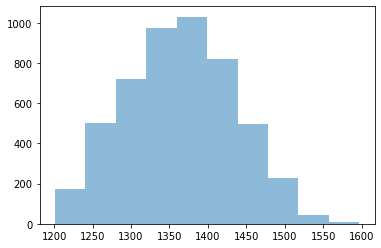

In [93]:
plt.hist(pred_counts, alpha=0.5);

In [124]:
df_pred = pd.DataFrame(columns=['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER'])


cnt = 6
for i in range(1,7):
    sample = (t.sample(n=round(np.random.choice(pred_count, size=1)[0]), 
                  replace=True, 
                  random_state=42)
         [['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER']]
         )
    cnt+=1
    
    sample['date'] = str(cnt)
    df_pred = pd.concat([df_pred,sample])
        
df_pred['SEASON'] = (df_pred['date']
                    .replace(['12','1','2'],'winter')
                    .replace(['3','4','5'],'spring')
                    .replace(['6','7','8'],'summer')
                    .replace(['9','10','11'],'autumn')
                    )

df_pred['date'] = (df_pred['date']
                   .replace(['7'],'2020-07')
                   .replace(['8'],'2020-08')
                   .replace(['9'],'2020-09')
                   .replace(['10'],'2020-10')
                   .replace(['11'],'2020-11')
                   .replace(['12'],'2020-12')
                  )
                   
df_pred['date'] = pd.to_datetime(df_pred['date'], format='%Y-%m')
                     
df_pred['PAID_AMOUNT'] = model_1.predict(df_pred[['SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'SEASON']])
df_pred

,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,date,SEASON,PAID_AMOUNT
50337,SpecialistFFS,General Surgery,Payer UN,2020-07-01,summer,1115.223640
50699,SpecialistFFS,Sleep Medicine,Payer S,2020-07-01,summer,311.879268
50014,OutpatientServices,HOSPITAL ACUTE CARE,Payer B,2020-07-01,summer,2366.504647
50524,SpecialistFFS,INFUSION PROVIDER,Payer F,2020-07-01,summer,3754.228244
50341,SpecialistFFS,Internal Medicine,Payer UN,2020-07-01,summer,3817.562898
...,...,...,...,...,...,...
49560,ERServices,FAMILY PRACTICE,Payer F,2020-12-01,winter,2697.031890
50113,OutpatientServices,PULMONARY DISEASES,Payer W,2020-12-01,winter,439.112366
49868,InpatientServices,Pulmonology,Payer UN,2020-12-01,winter,956.682095
50574,SpecialistFFS,NPFAM,Payer W,2020-12-01,winter,188.043100


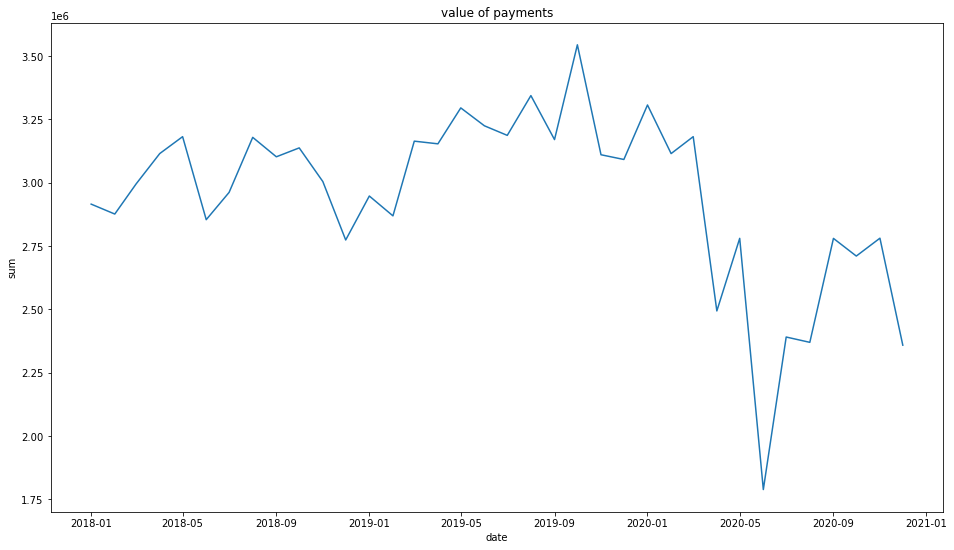

In [161]:
# Plot real date + forecasted 6 months
Y = pd.concat([df[['date','SERVICE_CATEGORY', 'CLAIM_SPECIALTY', 'PAYER', 'SEASON','PAID_AMOUNT']],
               df_pred]
             )
Y.set_index('date', inplace=True)


x = Y.groupby(Y.index)['PAID_AMOUNT'].agg(['sum']).index
y = Y.groupby(Y.index)['PAID_AMOUNT'].agg(['sum']).values
plt.figure(figsize=(16,9))
plt.plot(x,y)

plt.xlabel("date")
plt.ylabel("sum")
plt.title('value of payments');